# 2D limit plots

This notebook plots a 2D temperature limit plot of the observed excluded mu value as a function of $m_{\phi}$ (x-axis) and T (y-axis). Additionally, we plot both the observed and expected lines corresponding to $\mu=1$ to determine the phase space excluded in our model. The script firstly checks which limits converged, secondly, makes a 2D plot for a particular mass and decay mode, and finally loops through all masses and decay modes.

In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
import matplotlib
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
import os 
import scipy
import uproot
import glob
import yaml
import json
import math


import mplhep as hep
hep.style.use("CMS")
plt.style.use(hep.style.CMS)
matplotlib.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.dpi'] = 50
matplotlib.rcParams['figure.facecolor'] = 'white'
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
era = 2016
M = 800
decay = 'generic'
lumis = {
    2016 : 36.3, #36.308
    2017 : 41.5, #41.471 
    2018 : 59.8, #59.817
    'combined' : 59.8+41.5+ 36.3
}

decays = {
    'hadronic' : r"$A^' \rightarrow e^{+}e^{-},\mu^{+}\mu^{-},\pi^{+}\pi^{-}$""\n""with BR=15,15,70%",
    'leptonic' : r"$A^' \rightarrow e^{+}e^{-},\mu^{+}\mu^{-},\pi^{+}\pi^{-}$""\n""with BR=40,40,20%",
    'generic' : r"$A^' \rightarrow \pi^{+}\pi^{-}$""\n""with BR=100%"
}
           


In [3]:
# Define auxilary functions 

def get_limits(fn): # Returns quantile vs limits
    f = uproot.open(fn)
    limit = f["limit"]['limit'].array(library="np")
    quant = f["limit"]['quantileExpected'].array(library="np")
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit]) 
    
def get_SUEP_file(Mass=125, mdark=2, t=1, decay='generic', path="./"): # Returns filename
    if t < 10:
        tem = "{0:.2f}".format(t)
    else:
        tem = "{0:.1f}".format(t)
    tem = str(tem).replace(".","p")
    fname = os.path.join(
        "../higgsCombineGluGluToSUEP_HT1000_T{}_mS{:.3f}_mPhi{:.3f}_T{:.3f}_mode{}_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root".format(tem, Mass, mdark, t, decay)
    )
    if os.path.isfile(fname):
        return fname
    else:
        pass
     
def xs_scale(proc):
    xsec = 1.0
    with open(f"../config/xsections_{era}.json") as file:
            MC_xsecs = json.load(file)
    xsec  = MC_xsecs[proc]["xsec"] # Shouldn't I also multiply by this one --> will become evident!
    #xsec *= MC_xsecs[proc]["kr"]
    xsec *= MC_xsecs[proc]["br"]
    #xsec *= 1000.0
    assert xsec > 0, "{} has a null cross section!".format(proc)
    return xsec

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log(xx)
    logy = np.log(yy)
    lin_interp = interpolate.interp1d(logx, logy, bounds_error=False, fill_value="extrapolate", kind=kind)
    log_interp = lambda zz: np.power(np.e, lin_interp(np.log(zz)))
    return log_interp

In [4]:
combine_files = glob.glob("../higgs*.root")
# print(combine_files)


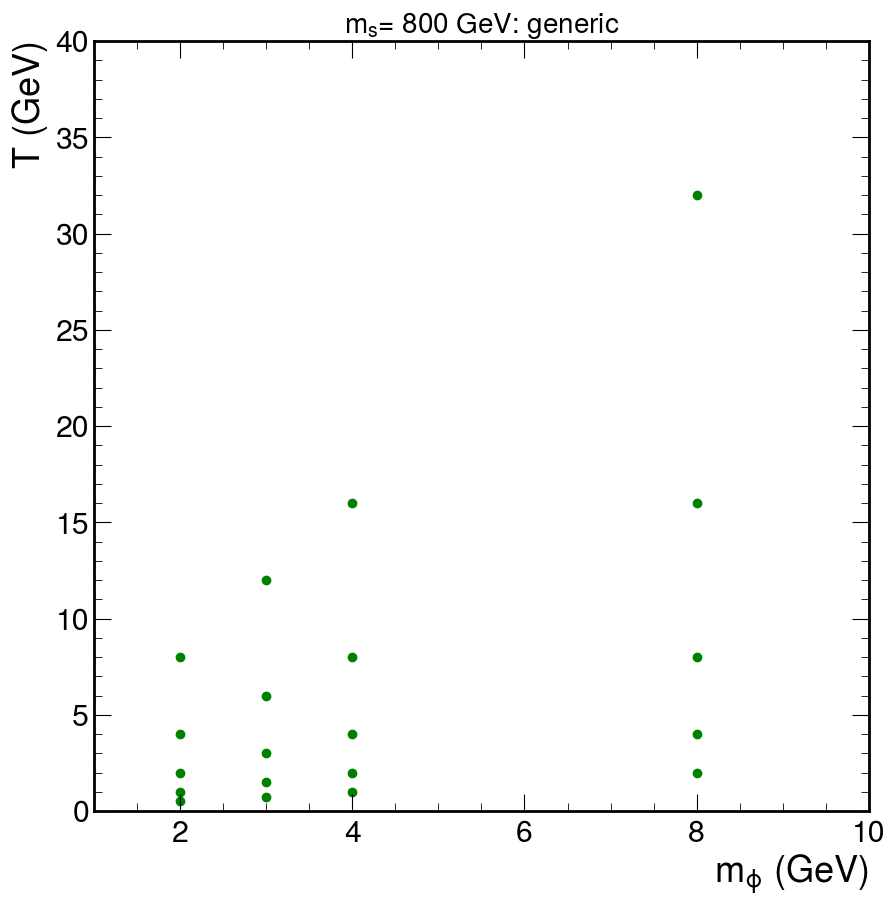

In [5]:
# Get all SUEP masses for a given mdark and T

def get_params(M=M,decay=decay):

    # Get files
    combine_files = glob.glob("../higgs*.root")

    # Filter out the parameters
    all_params = []
    for file in combine_files:
        try: file_trim = file.split("HT1000_")[1]
        except: print(file)
        proc = 'GluGluToSUEP_HT1000_' + file_trim.split('.Asymptotic')[0]
        xsec = xs_scale(proc)
        t = float(file_trim.split("_")[0].replace("p",".")[1:])
        Mass = float(file_trim.split("_")[1][2:])
        mphi = float(file_trim.split("_")[2][4:])
        mode = file_trim.split('_')[4][4:]
        all_params.append([t,Mass,mphi,xsec,mode])

    # Take params corresponding to correct SUEP mass and decay mode
    params = []
    for pair in all_params:
        if pair[1] != M: continue
        if pair[4] != decay: continue
        params.append([pair[2],pair[0],pair[3]]) #[mphi,t,decay]
    # print('params', params)

    # check if combine produced the 5 expected limits
    skip_bad = []

    for pair in params:
        try:
            limit = get_limits(get_SUEP_file(Mass=M, mdark=pair[0], t=pair[1], decay=decay))
            if limit.shape == (2,6):
                plt.scatter(pair[0],pair[1], color="green")
                skip_bad.append(pair)
            else:
                print('Missing limits; ', get_SUEP_file(Mass=M, mdark=pair[0], t=pair[1], decay=decay))
                plt.scatter(pair[0],pair[1], color="blue")

        except:
            print('No limits; ', get_SUEP_file(Mass=M, mdark=pair[0], t=pair[1], decay=decay))
            plt.scatter(pair[0],pair[1], color="red")

    plt.ylim([0, 40])
    plt.xlim([1, 10])
    plt.xlabel(r"$m_{\phi}$ (GeV)", x=1, ha='right')
    plt.ylabel(r"$T$ (GeV)", y=1, ha='right')
    plt.title(r'$m_{{s}}$= {} GeV: {}'.format(M,decay),fontsize=20)
    plt.show()

    
    return skip_bad


params = get_params()


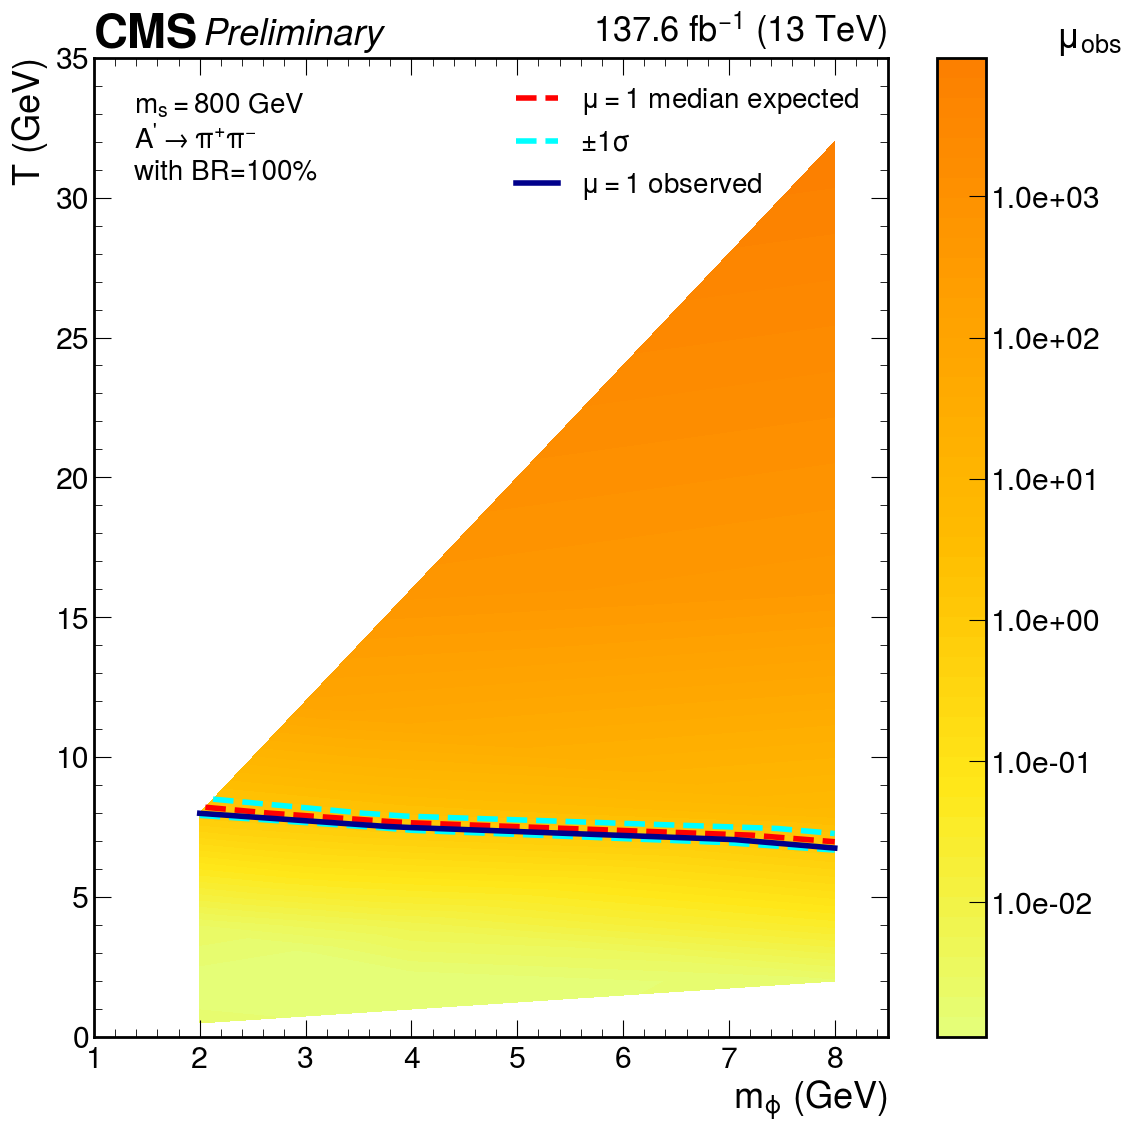

In [17]:
#Plots a 2D limit plot
def plot_SUEP(params=params,unblind=False,tricontour='log'): 
    
    if tricontour not in ['log','lin']: #tricontour decides whether we interpolate through mu ('lin') or log(mu) ('log')
        raise Exception("tricontour should be 'log' or 'lin'")
    
    # Reorganize data
    limit_mH = [] # T
    limit_ma = [] # mphi
    limit_lm = [] # results for mu
    limit_xs = []
    return_limit = []

    for pair in params:
        limit = get_limits(get_SUEP_file(Mass=M, mdark=pair[0] ,t=pair[1] ,decay=decay))
        limit = limit #* pair[2] # To plot the xsection rather than mu
        if limit.shape == (2, 6):
            limit_lm.append(limit)
            limit_ma.append(pair[0])
            limit_mH.append(pair[1])
            return_limit.append([pair[0], pair[1], limit[1,2]])
            limit_xs.append(pair[2])
        else: 
            continue

    limit_lm = np.array(limit_lm)
    limit_mH = np.array(limit_mH)
    limit_ma = np.array(limit_ma)
    limit_xs = np.array(limit_xs)
    
    if tricontour == 'log':
        limit_lm[:,1,:]= np.log10(limit_lm[:,1,:]) # Convert mu to logarithm of mu 
    
    data = pd.DataFrame(
        {
            "mH"  : np.array(limit_mH),
            "ma"  : np.array(limit_ma),
            "m2s" : np.array(limit_lm)[:,1,0],
            "m1s" : np.array(limit_lm)[:,1,1],
            "exp" : np.array(limit_lm)[:,1,2],
            "p1s" : np.array(limit_lm)[:,1,3],
            "p2s" : np.array(limit_lm)[:,1,4],
            "obs" : np.array(limit_lm)[:,1,5],
        }
    )
    

    # Plot figure and obtain mu=1 (log(mu)=0) lines
    
    plt.figure(figsize=(12,12))
    ax = plt.gca()
    
    if tricontour == 'log':
        levels = np.linspace(min(data['obs']),max(data['obs']))
        plt.tricontourf(limit_ma, limit_mH, data['obs'], levels =levels, cmap="Wistia")

        #get the colorbar right
        cb = plt.colorbar()
        cb.set_label(r'$\mu_{obs}$',labelpad=15,rotation=0,va='bottom')
        ticks = (np.array(range(math.ceil(min(data['obs'])), math.floor(max(data['obs'])) + 1)))
        cb.set_ticks(ticks)
        labels = ['{:.1e}'.format(i) for i in np.power(10., ticks)]
        cb.set_ticklabels(labels)      
         

    if tricontour == 'lin':
        levels = np.logspace(np.log10(min(data['obs'])),np.log10(max(data['obs'])))
        x = plt.tricontourf(limit_ma, limit_mH, data['obs'], levels =levels,locator=ticker.LogLocator(), cmap="Wistia")
        formatter = ticker.LogFormatter(base=10, labelOnlyBase=True) 
        cb = plt.colorbar(format=formatter, label=r'$\mu$')
        cb.ax.set_ylabel(r'$\mu$', rotation=0, va='center', fontsize=20)
        cb.locator = ticker.LogLocator(base=10.0, subs=[1.0], numdecs=7, numticks=45)
        cb.update_ticks()
     
    
    # Obtain values for expected mu=1 line
    
    # p0 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,0],levels=[0,1], colors="k", alpha=0) # -2 sigma expected
    p1 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,1],levels=[0,1],   colors="k", alpha=0) # -1 sigma expected
    p2 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,2],levels=[0,1],   colors="k", alpha=0) # median expected
    p3 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,3],levels=[0,1],  colors="k", alpha=0) # +1 sigma expected
    # p4 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,4],levels=[0,1],  colors="k", alpha=0) # +2 sigma expected
    p5 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,5],levels=[0,1],  colors="k", alpha=0) # observed
    
    if tricontour == 'log': x=0
    if tricontour == 'lin': x=1 
    line1 = np.array(p1.collections[x].get_paths()[0].vertices)
    line2 = np.array(p2.collections[x].get_paths()[0].vertices)
    line3 = np.array(p3.collections[x].get_paths()[0].vertices)
    # line4 = np.array(p4.collections[x].get_paths()[0].vertices)
    #line0 = np.array(p0.collections[x].get_paths()[0].vertices)
    line5 = np.array(p5.collections[x].get_paths()[0].vertices)

    #plot smoothed curve
    plt.plot(*line2.T, linestyle = "--", color ='red' , label=r"$\mu=1$ median expected",linewidth =4)
    plt.plot(*line1.T,linestyle = "--", color='#00ffff', label=r"$\pm 1\sigma$",linewidth =4)
    plt.plot(*line3.T, linestyle = "--", color='#00ffff', linewidth =4)
    plt.plot(*line5.T, linestyle = "-", color='#00008b', label=r"$\mu=1$ observed",linewidth =4)


        
    plt.xlabel(r"$m_{\phi}$ (GeV)", x=1, ha='right')
    plt.ylabel(r"$T$ (GeV)", y=1, ha='right')
    
    hep.cms.label(llabel='Preliminary', data=False, lumi=lumis['combined'], ax=ax) # To add CMS lumi scripts

    
    info = plt.text(
        0.05, 0.87, r"$m_{{s}} = {}$ GeV""\n""{}".format(str(M),decays[decay]),
        fontsize=20, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
        
    )
    
    plt.xlim([1, 8.5])
    plt.ylim([0, 35])     
    plt.legend(loc="upper right", fontsize=20)
    plt.tight_layout()
    
    
    # if not os.path.exists('plots'):
    #     os.makedirs('plots')
    # plt.savefig("/home/submit/pvanstee/public_html/SUEP/AN_unblinding/color_T_mdark_2D_limits_m{}_{}_{}.pdf".format(M,decay,era), bbox_inches='tight')
    # plt.savefig("/home/submit/pvanstee/public_html/SUEP/AN_unblinding/Color_T_mdark_2D_limits_m{}_{}_{}.png".format(M,decay,era), bbox_inches='tight')
    
    plt.show()

plot_SUEP()



Missing limits;  ../higgsCombineGluGluToSUEP_HT1000_T16p0_mS125.000_mPhi4.000_T16.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root
Missing limits;  ../higgsCombineGluGluToSUEP_HT1000_T16p0_mS125.000_mPhi8.000_T16.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root
Missing limits;  ../higgsCombineGluGluToSUEP_HT1000_T32p0_mS125.000_mPhi8.000_T32.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root


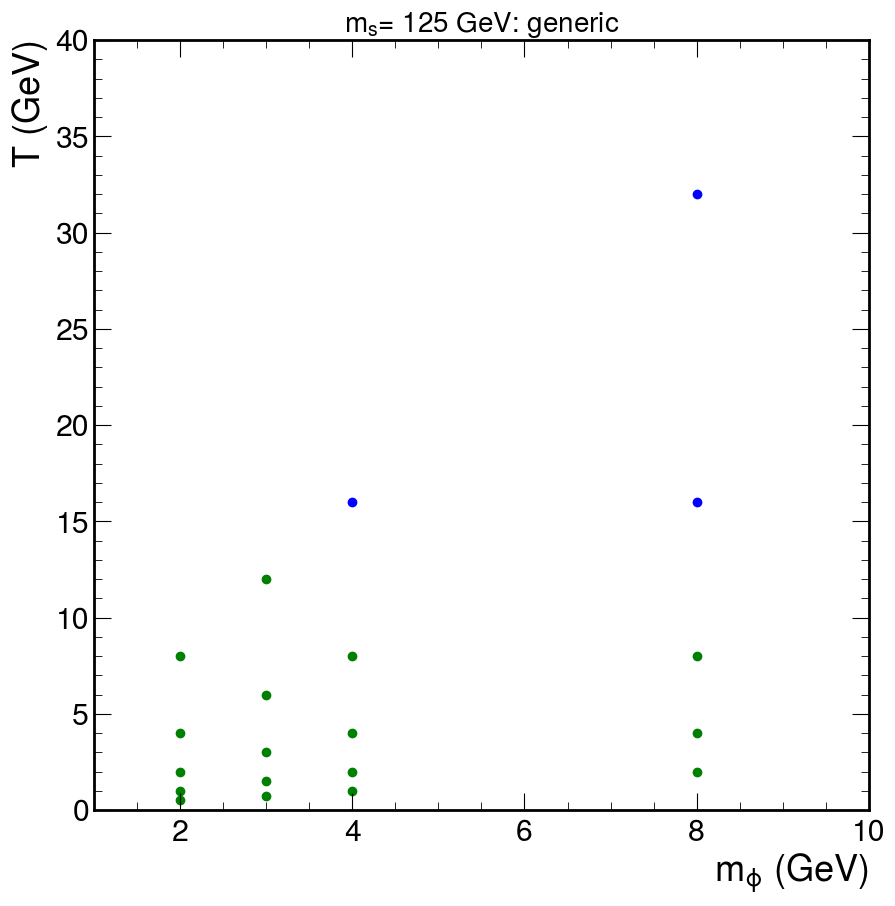

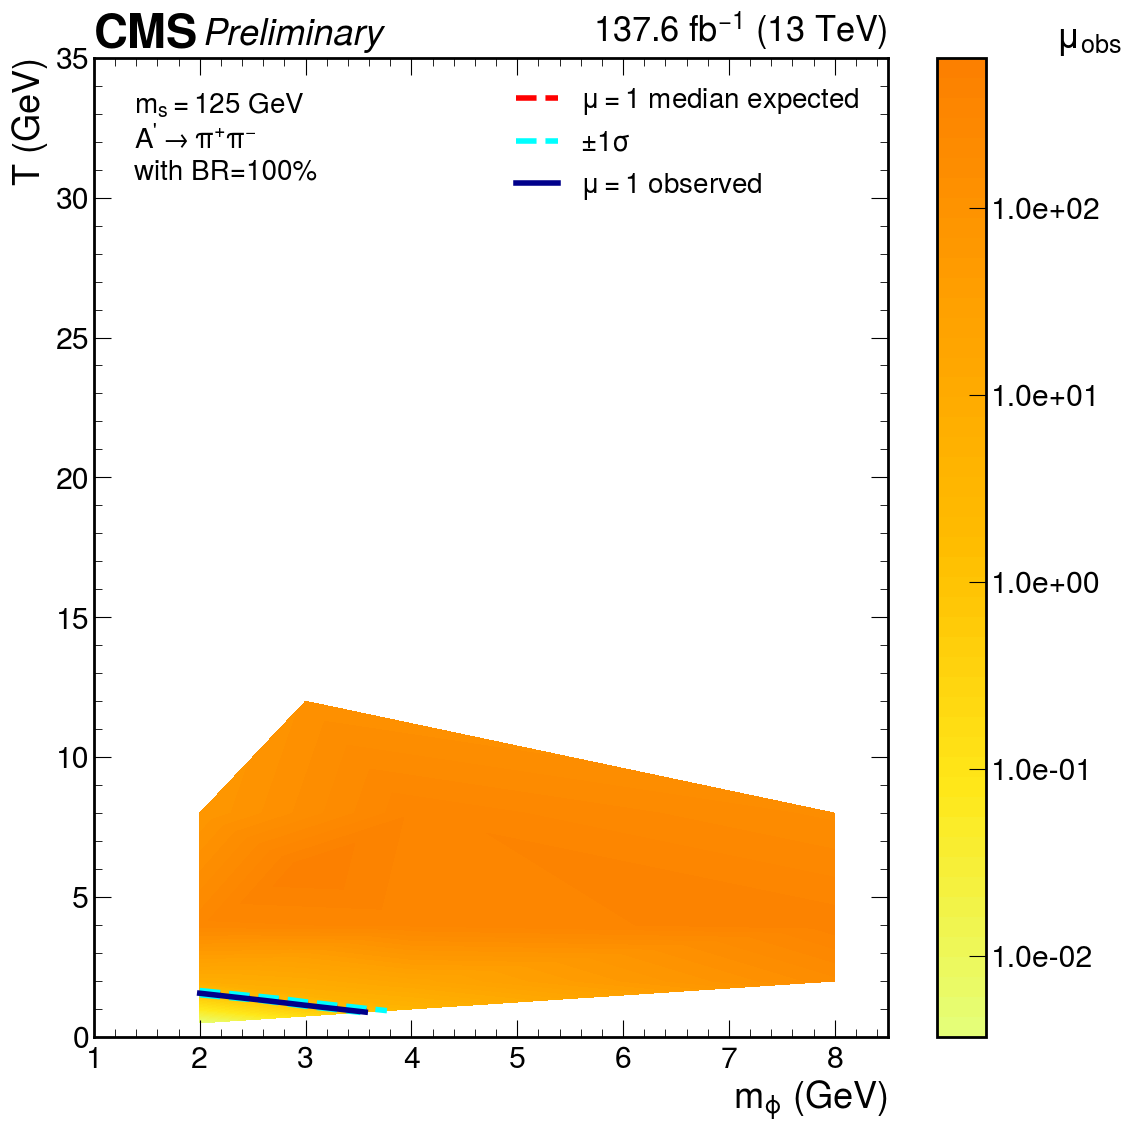

Missing limits;  ../higgsCombineGluGluToSUEP_HT1000_T32p0_mS200.000_mPhi8.000_T32.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root


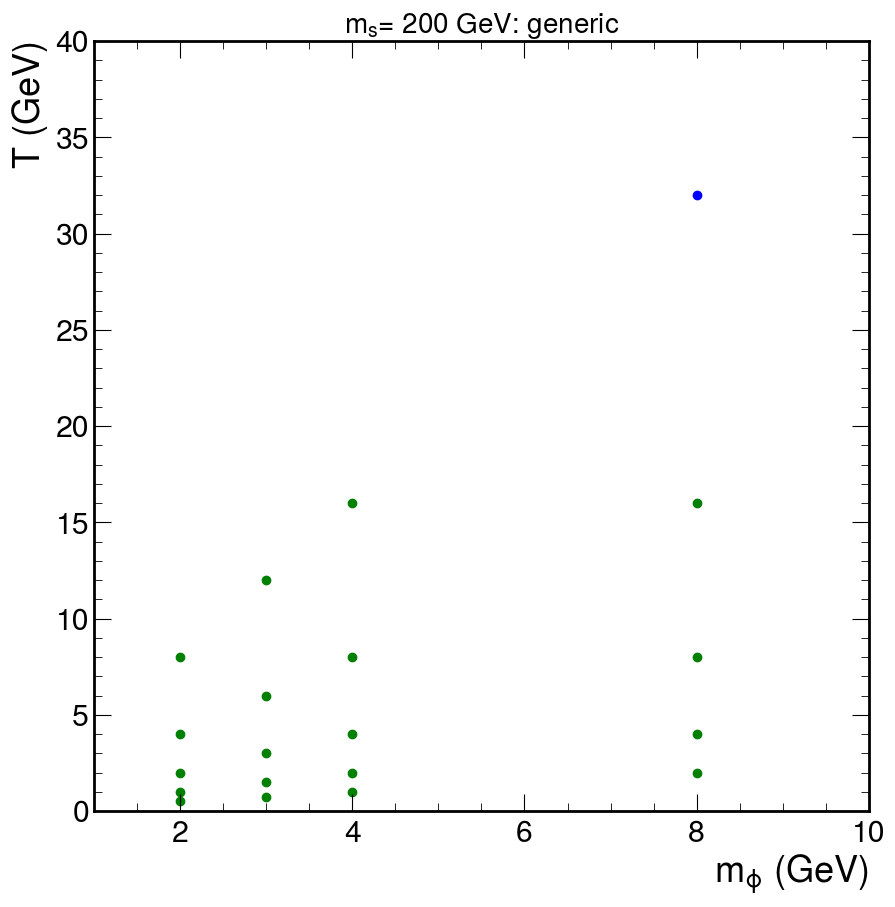

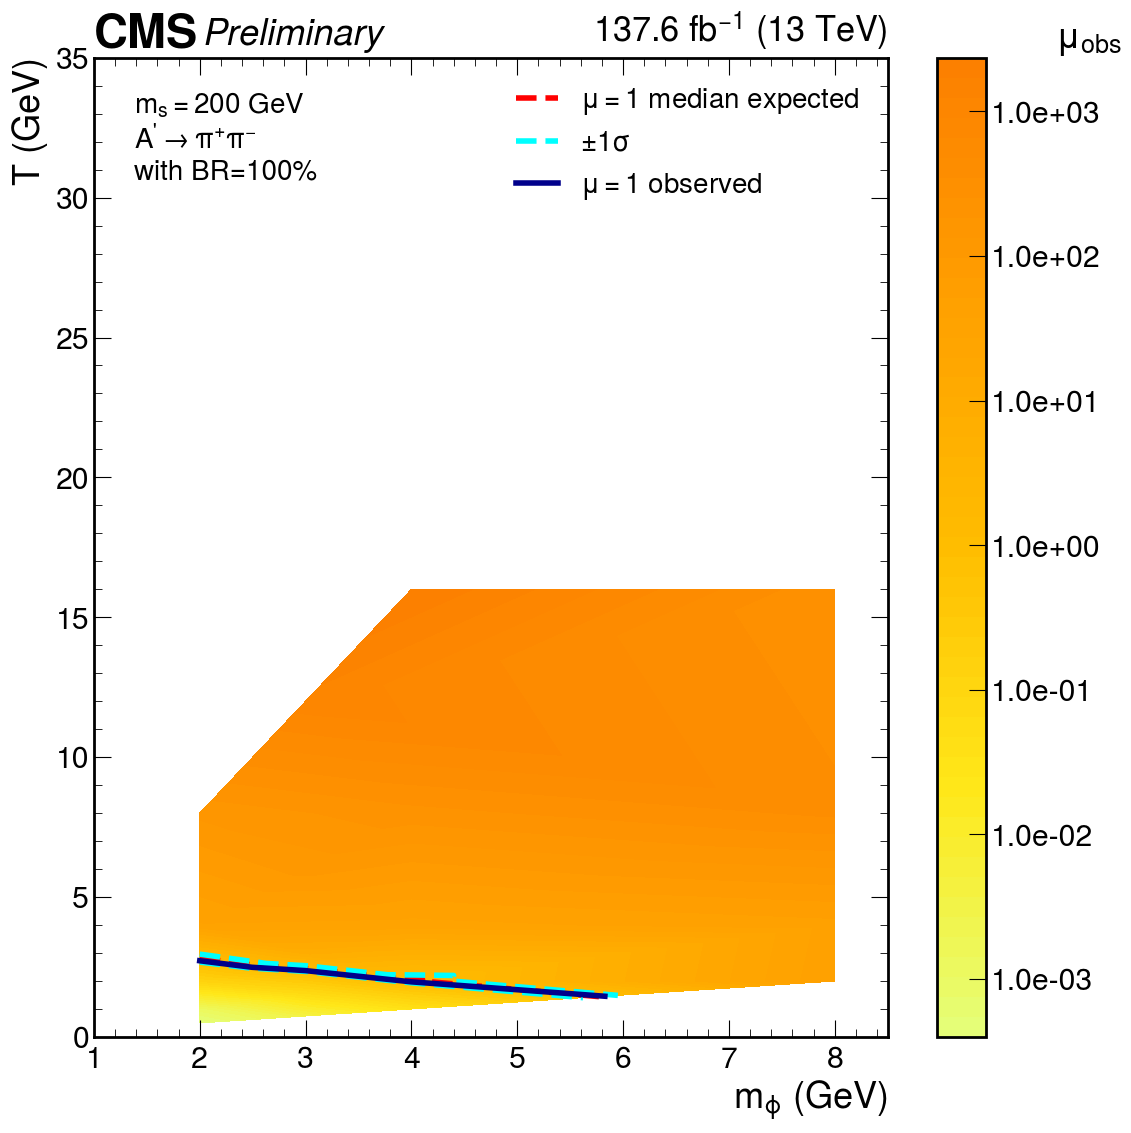

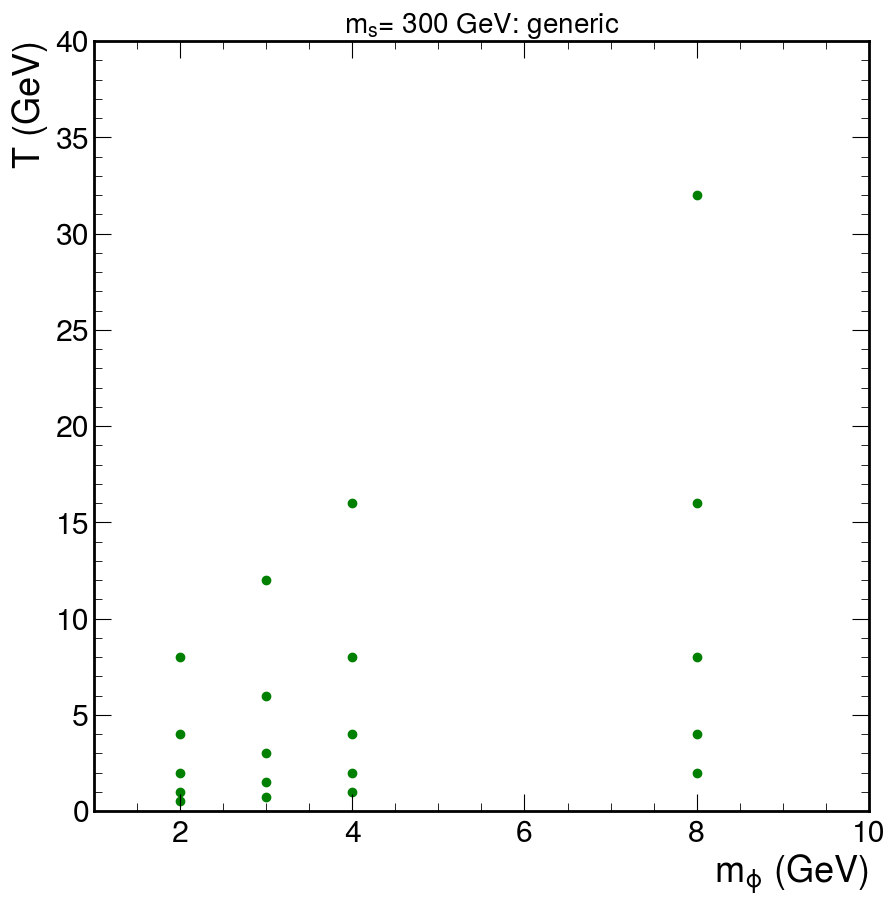

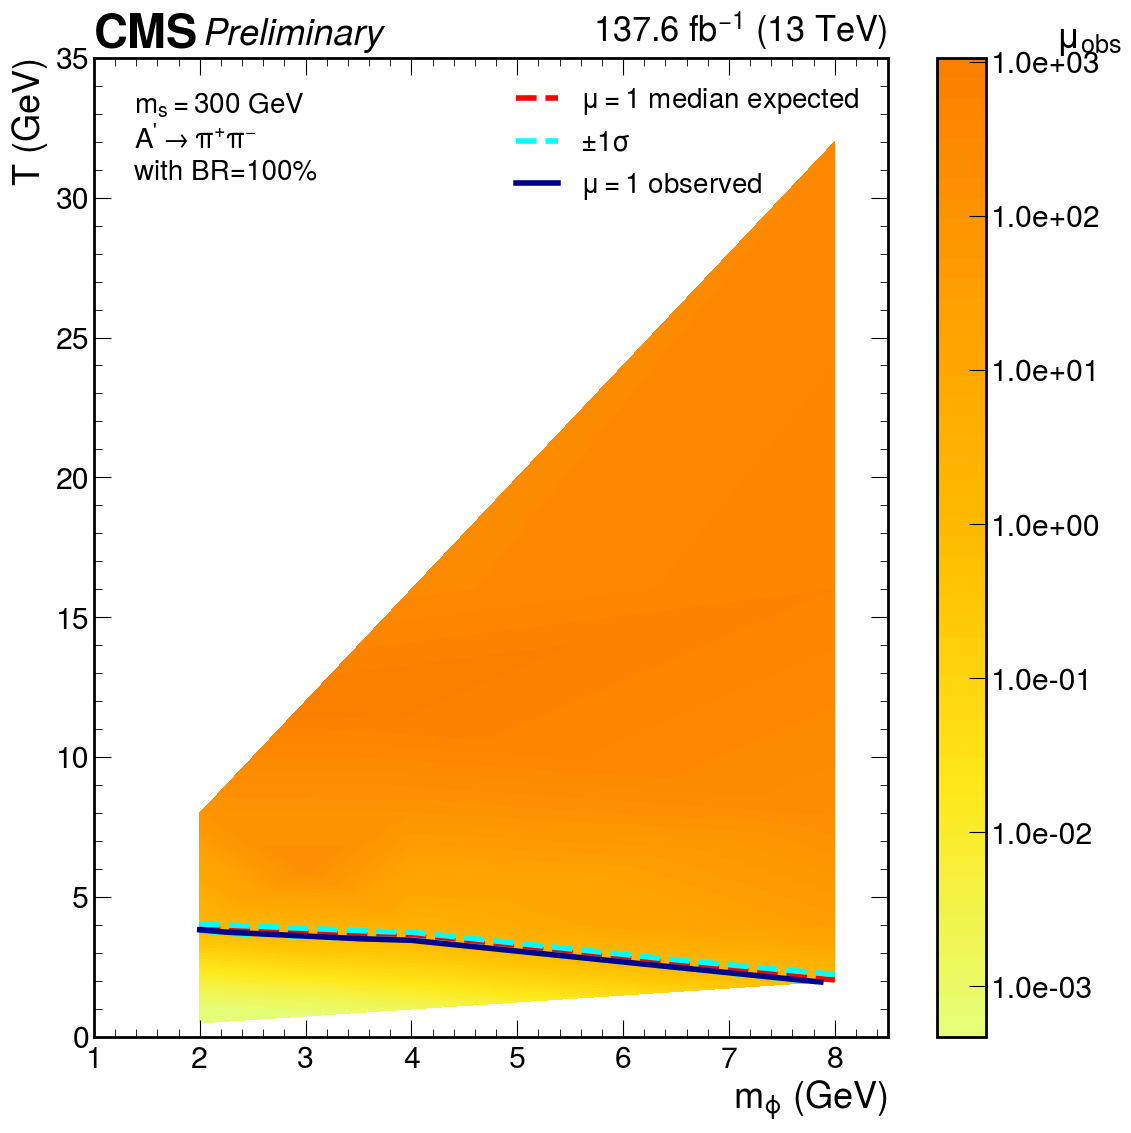

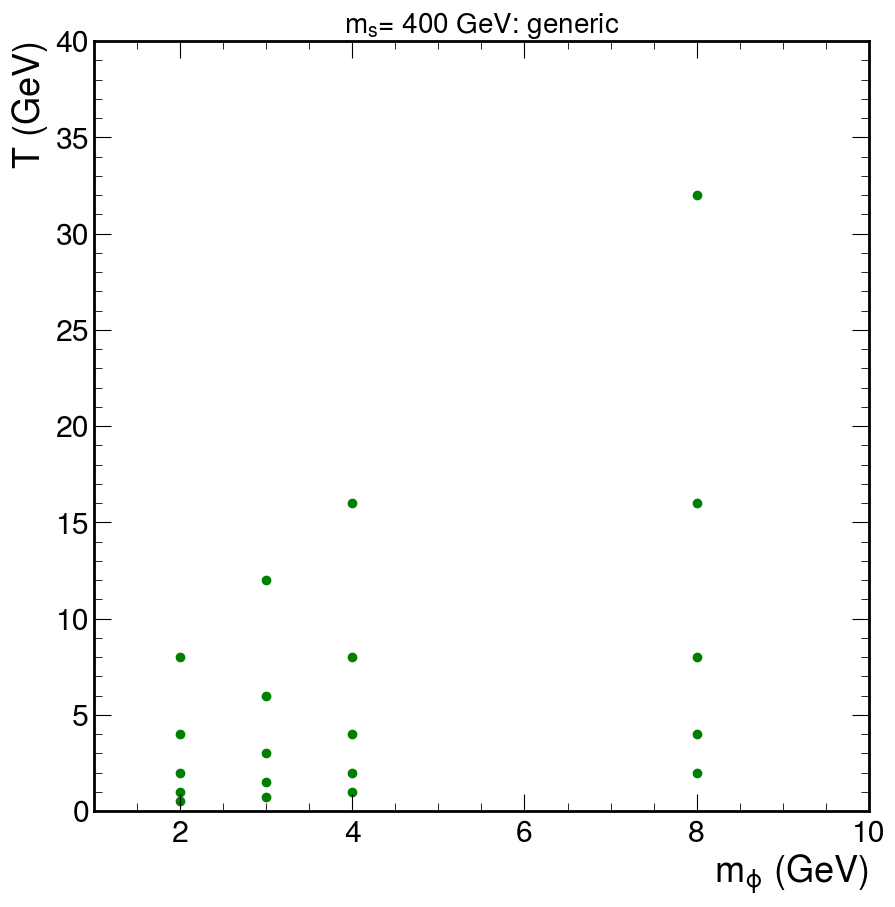

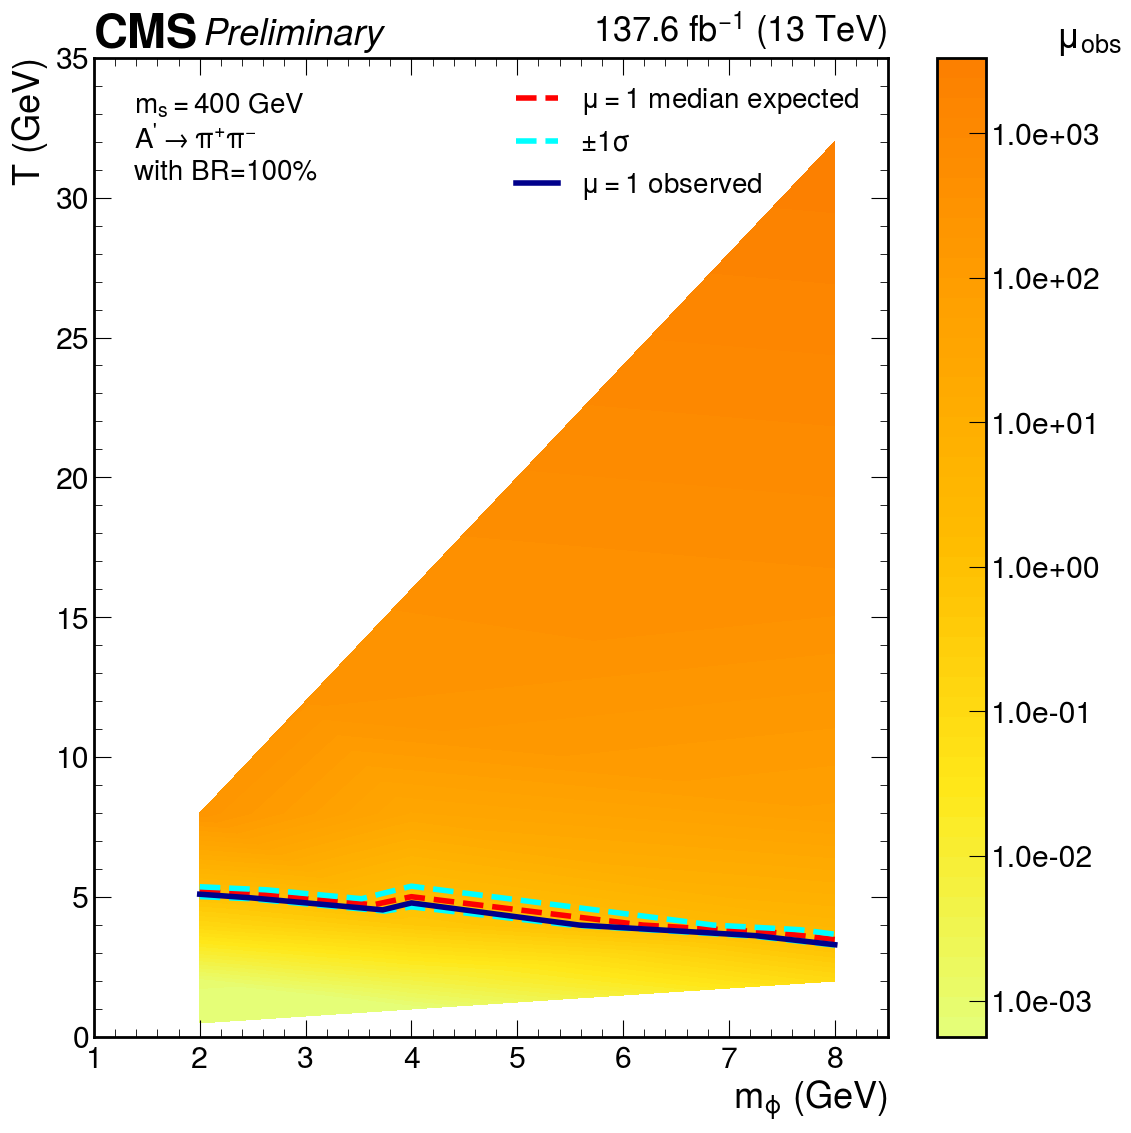

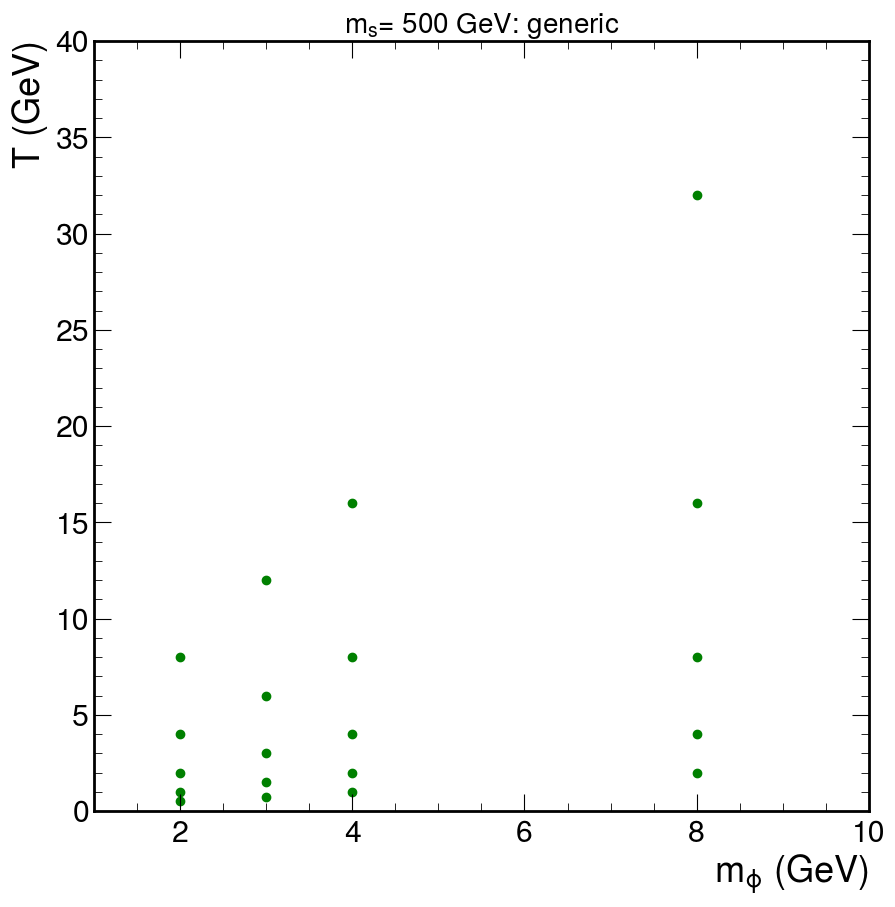

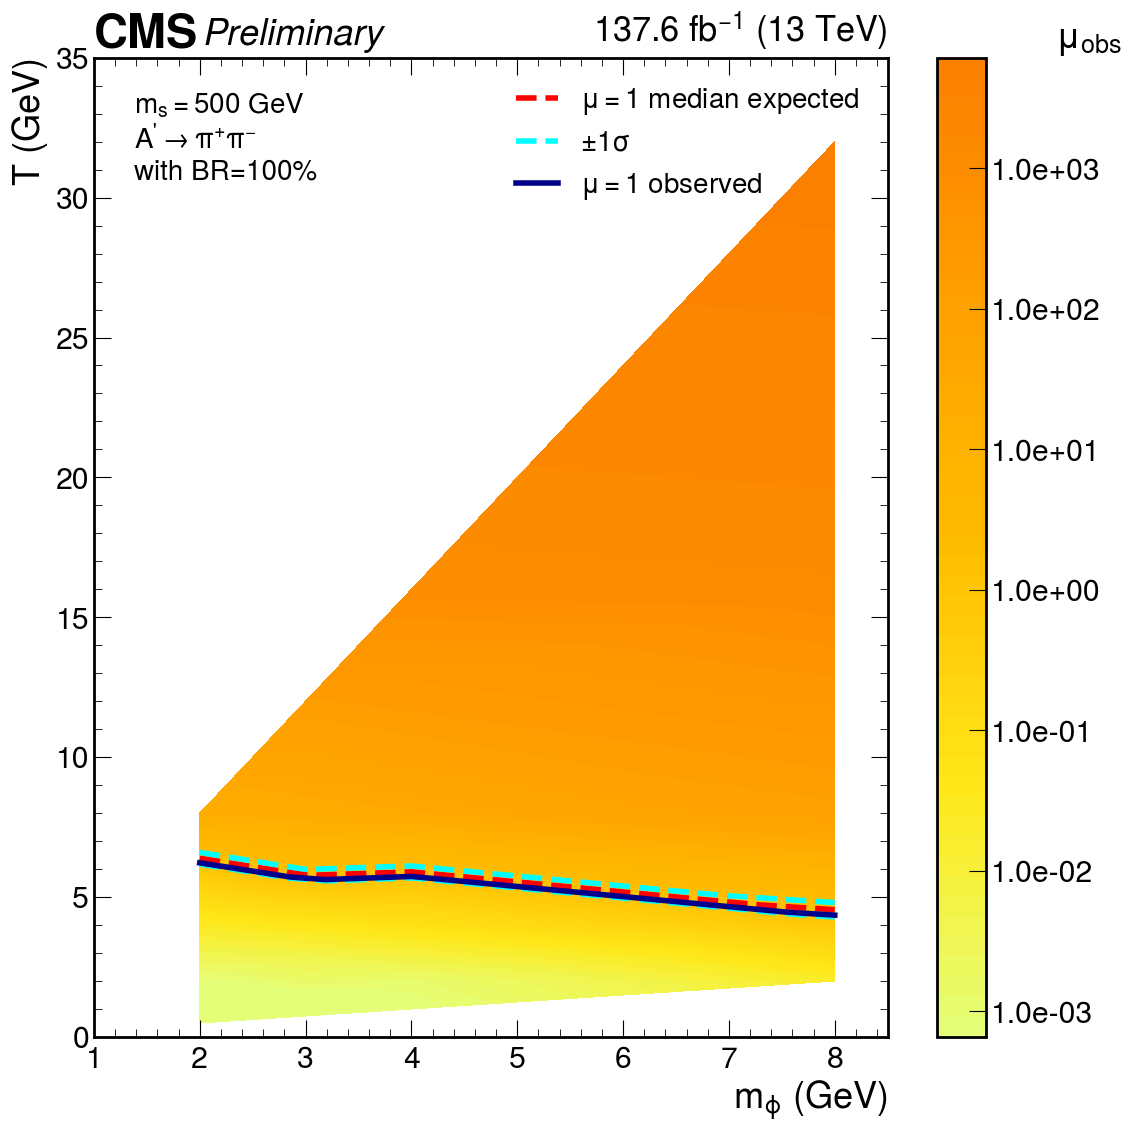

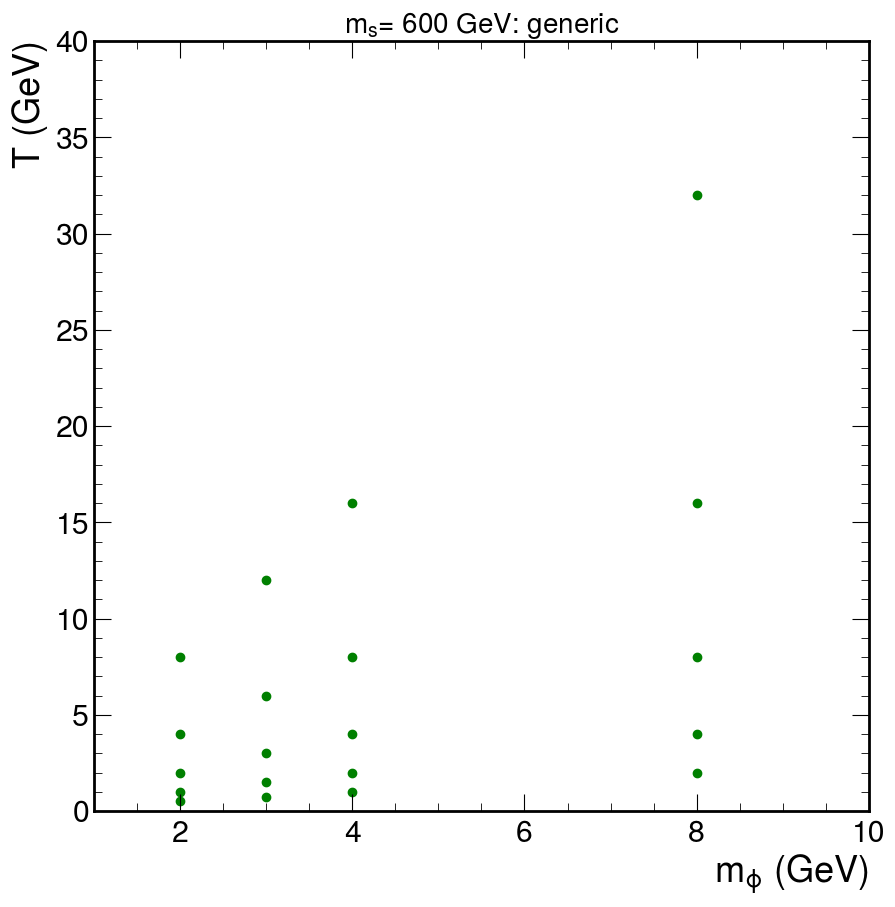

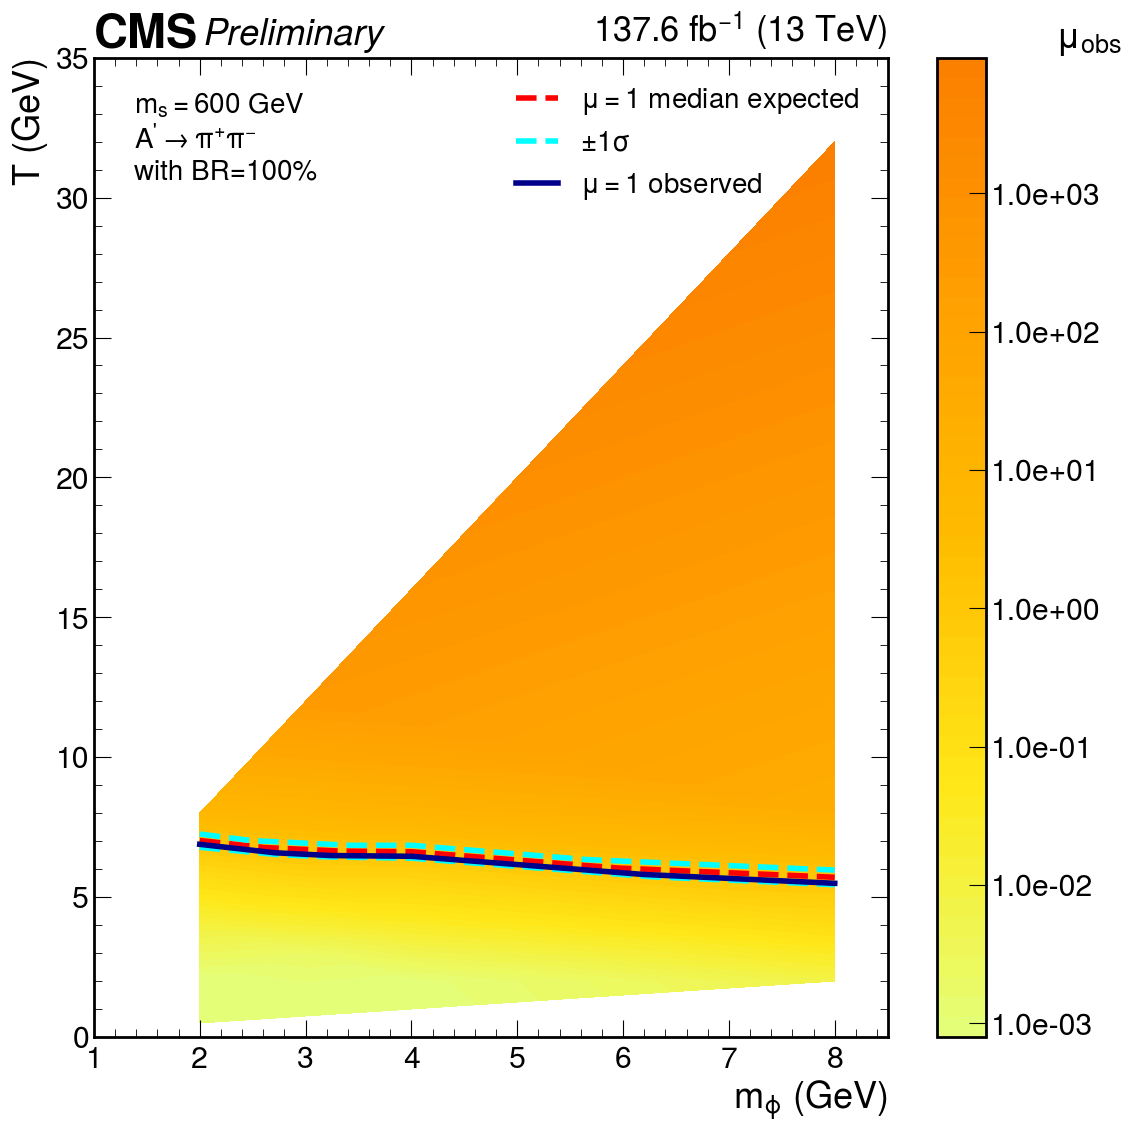

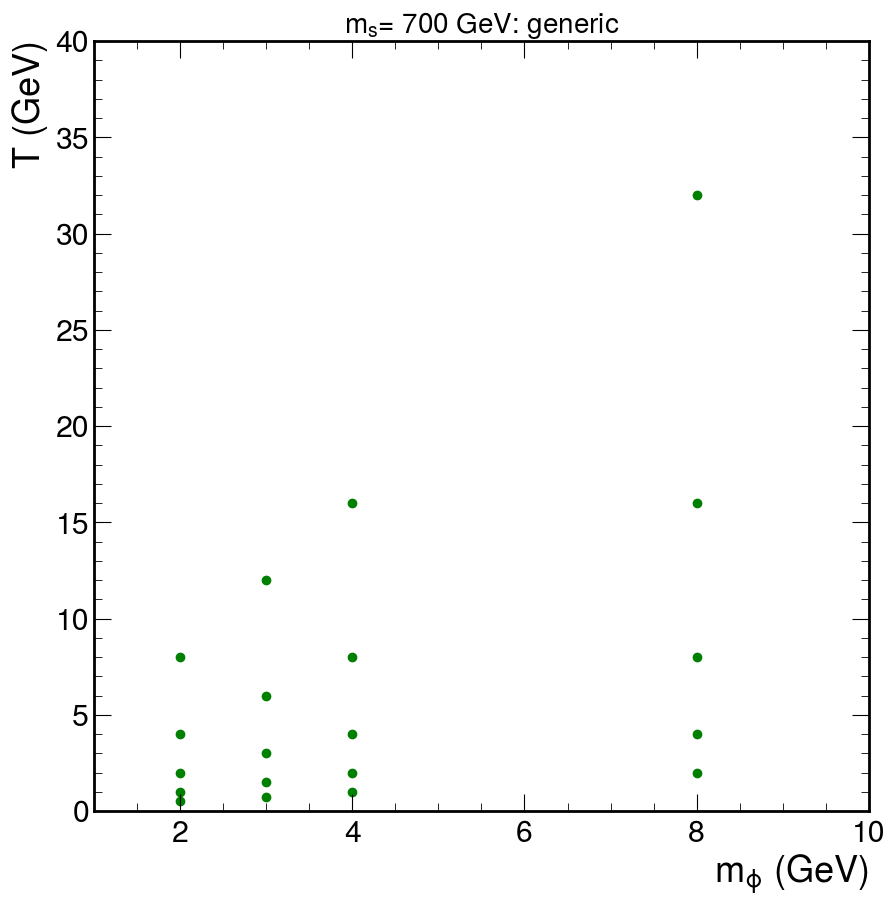

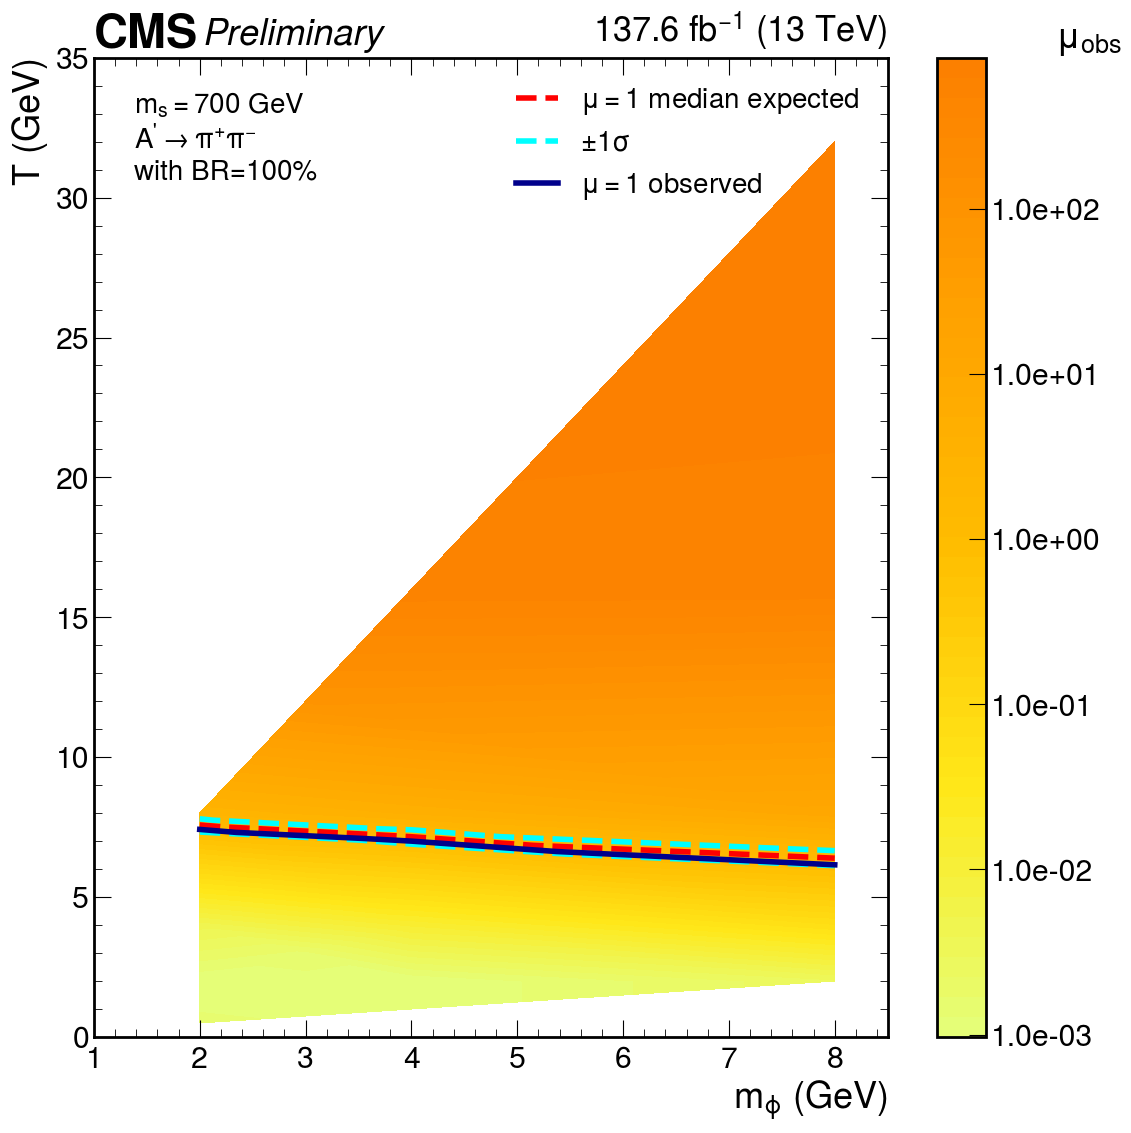

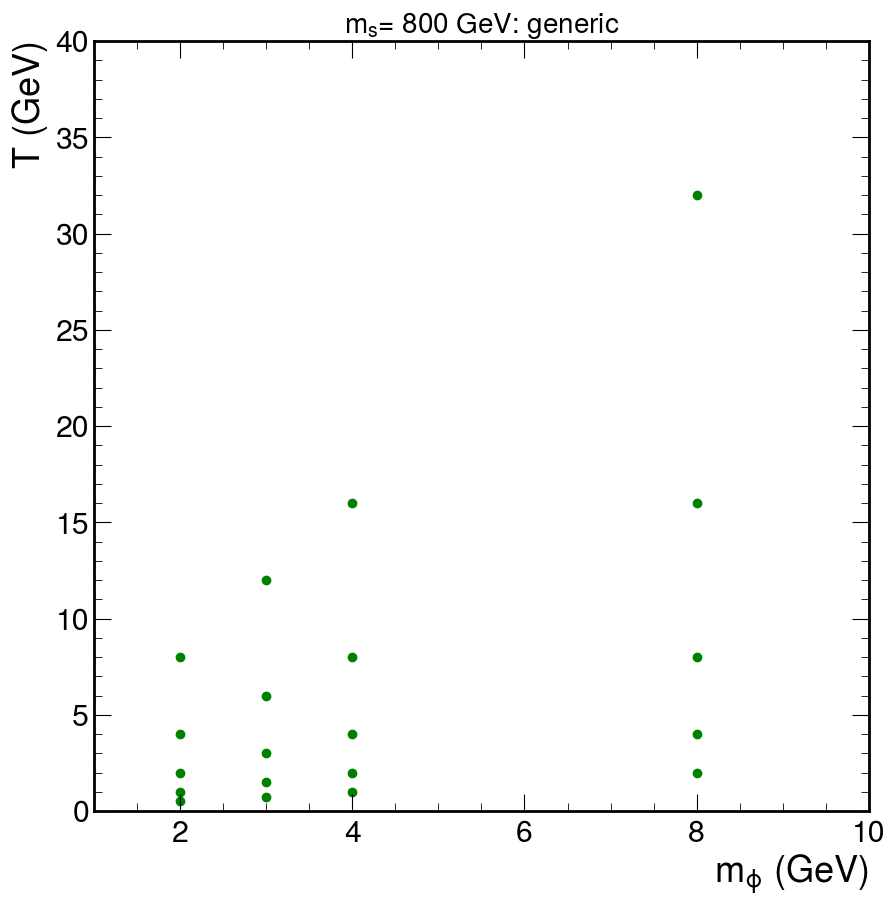

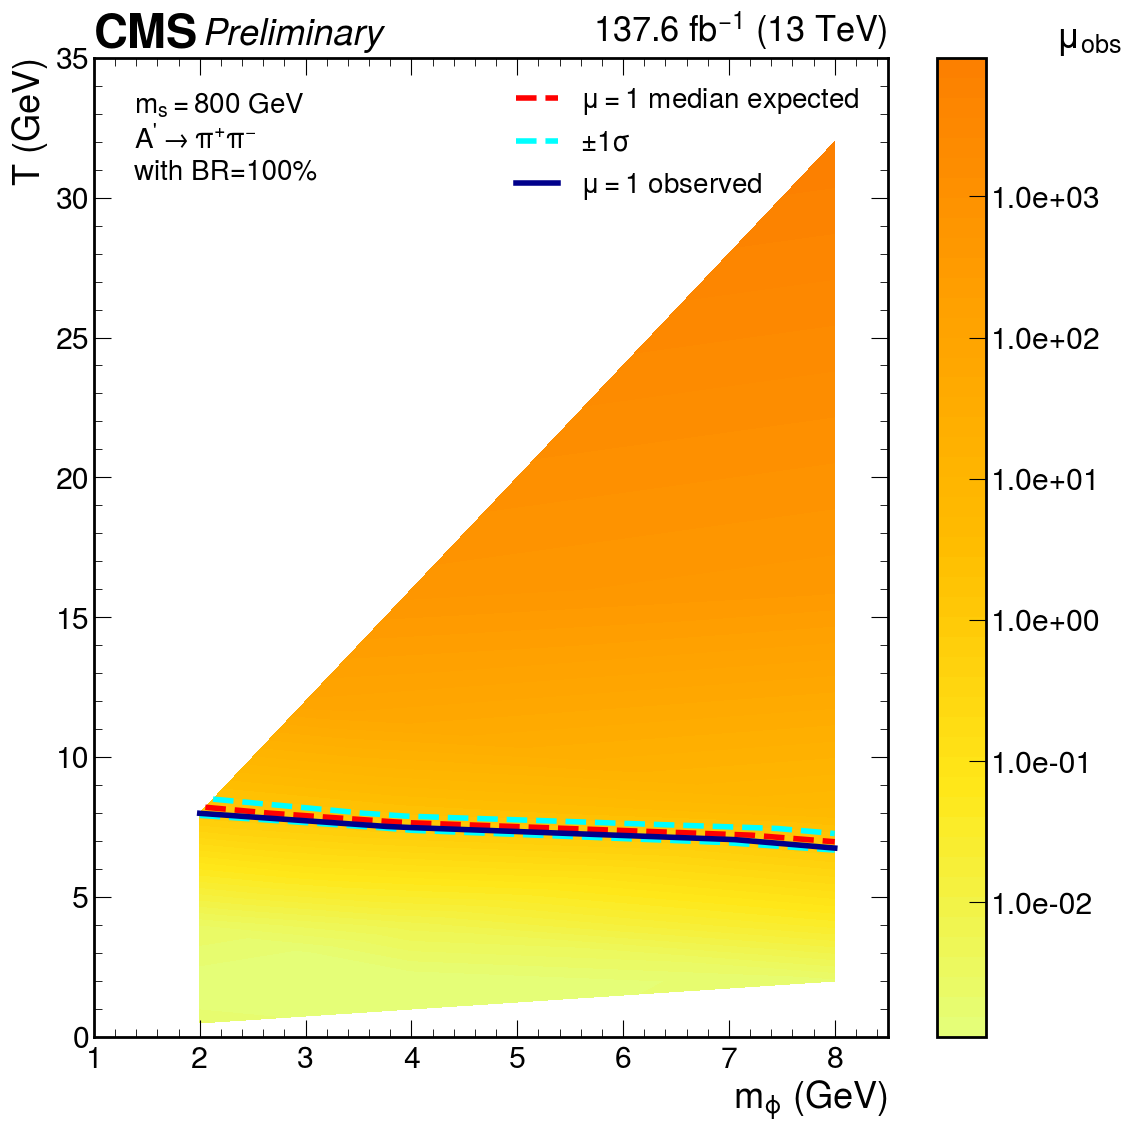

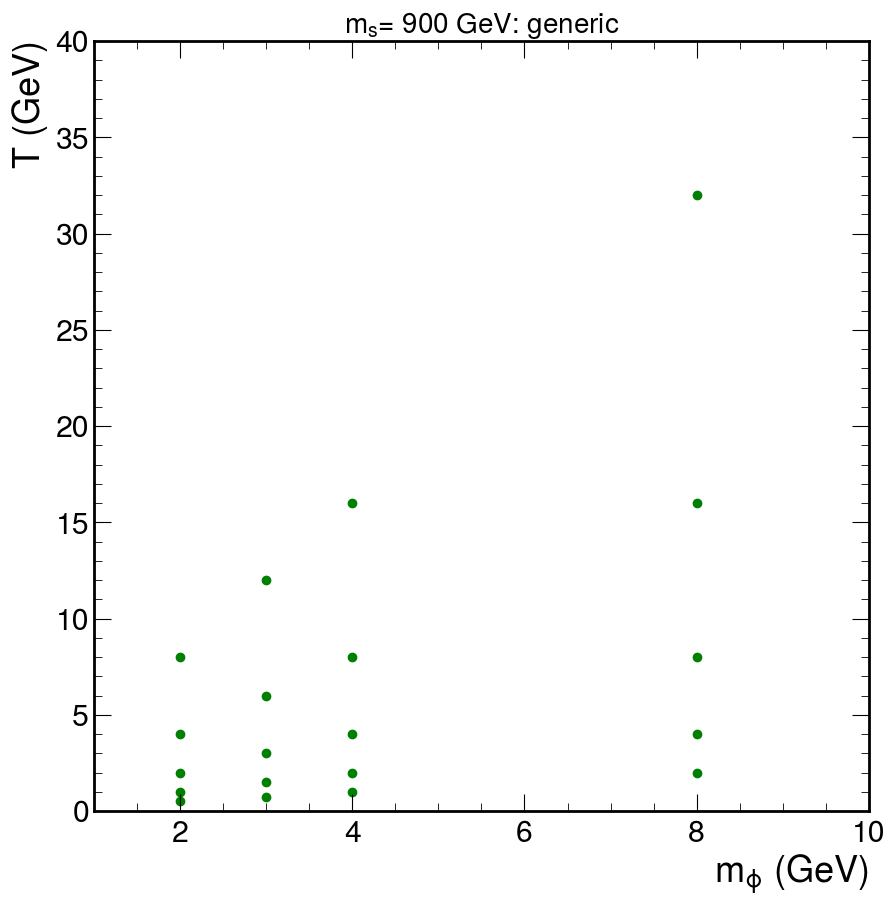

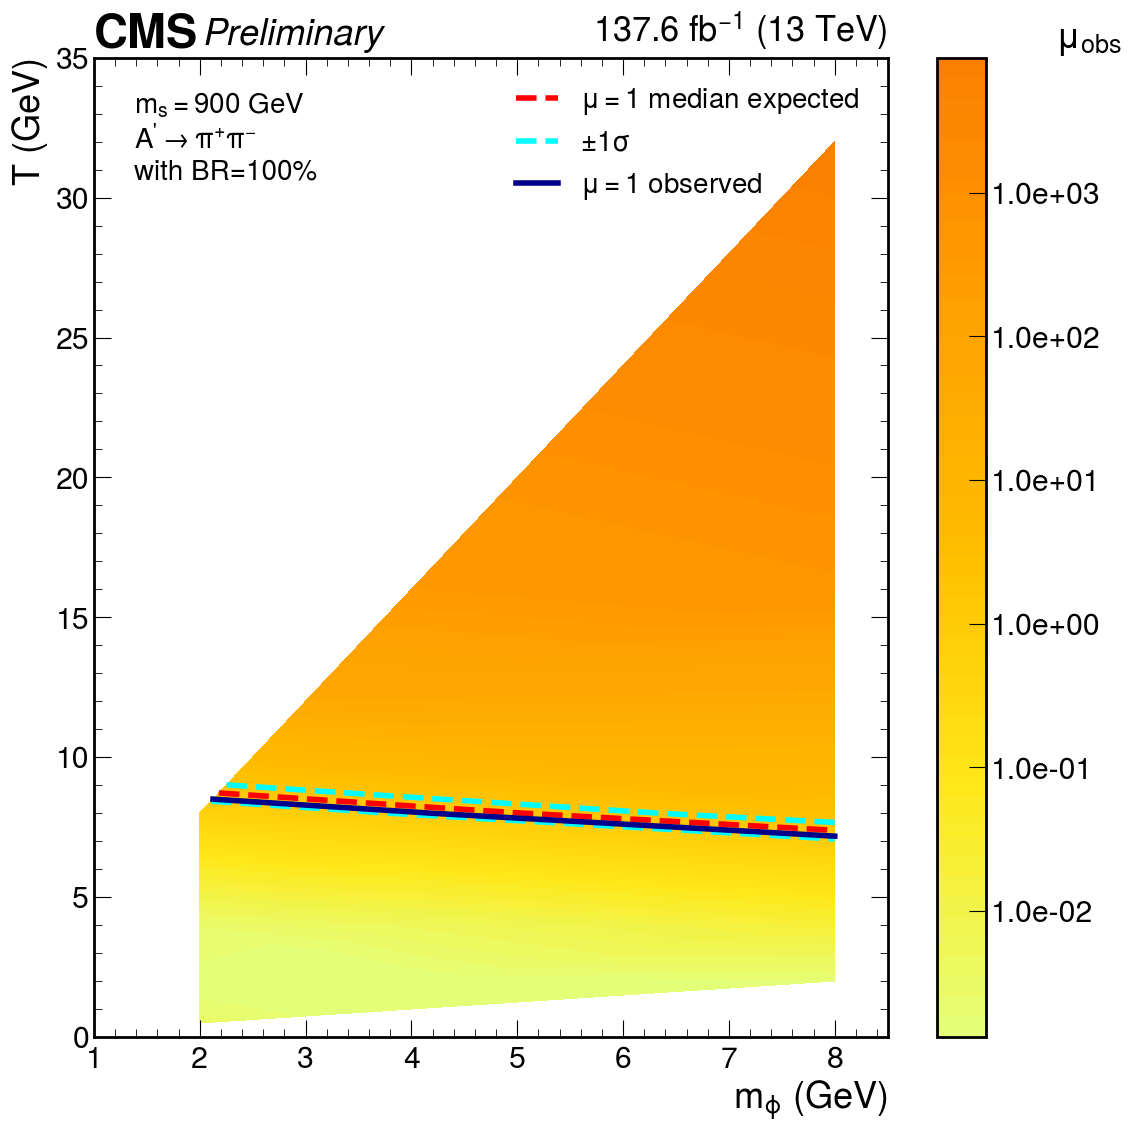

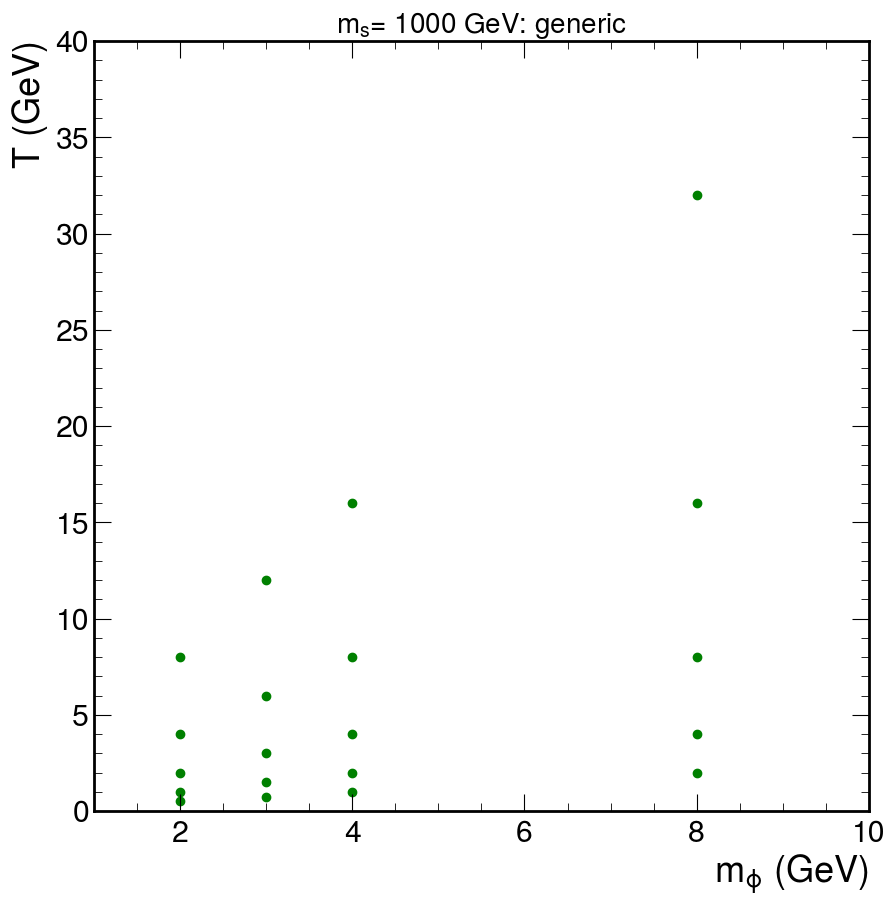

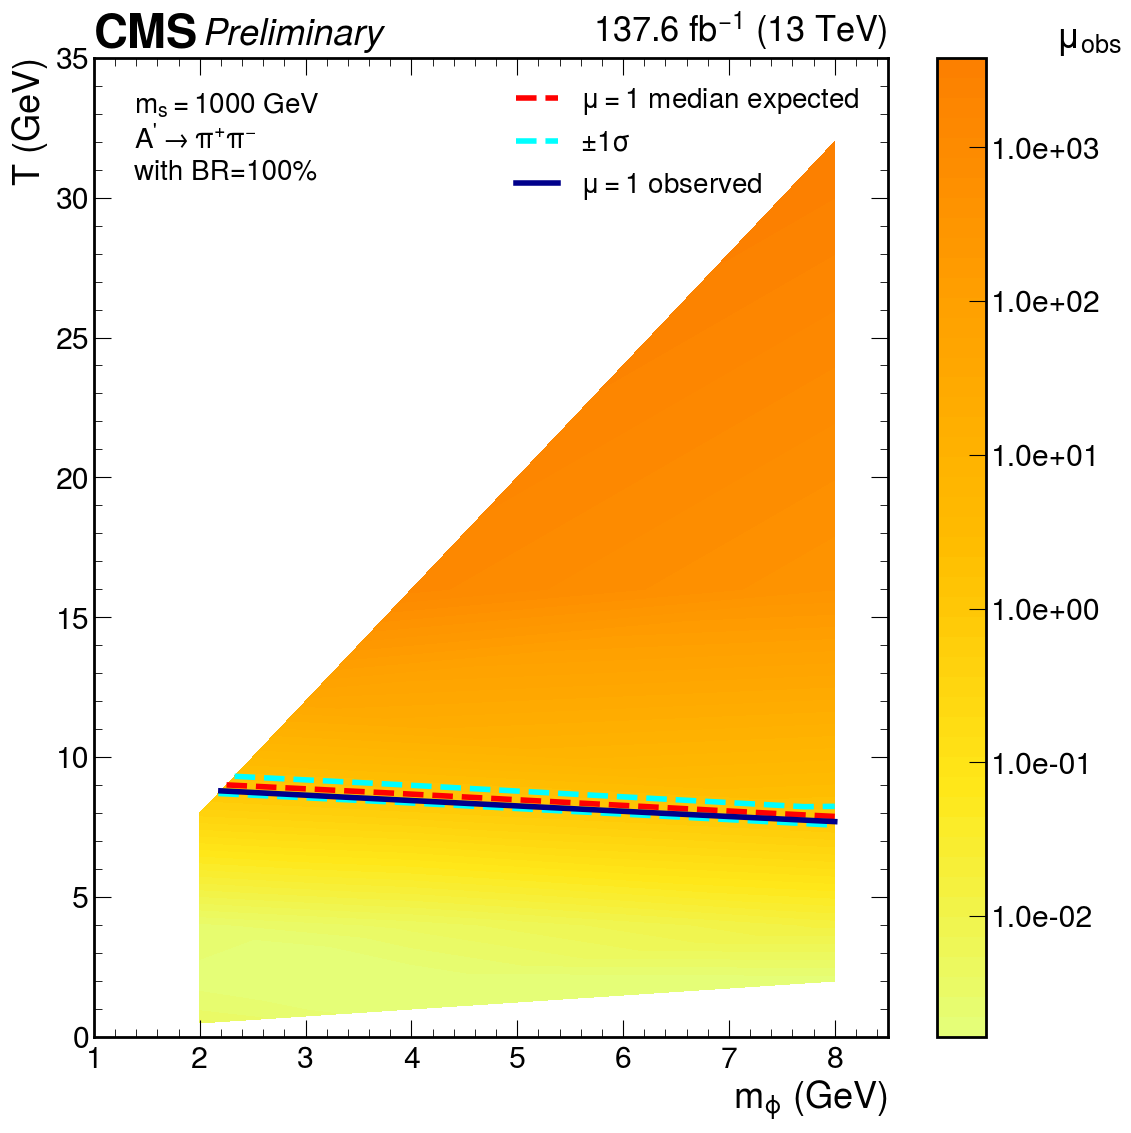

In [18]:
# To run through all masses

for M in [125,200,300,400,500,600,700,800,900,1000]:
    for decay in ['generic']:
        params = get_params(M,decay)
        if params == []: continue
        plot_SUEP(params)


In [19]:
from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D


class HandlerDashedLines(HandlerLineCollection):
    """
    Custom Handler for LineCollection instances.
    """
    def create_artists(self, legend, orig_handle,
                   xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go

        ydata = (height/2.7) * np.ones(len(xdata), float)
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - 2*i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
                #print ('dashes : ', dir(orig_handle))
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
                #print ('dashes -> ', 0)
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] != None:
                legline.set_dashes(dashes[1])
            else:
                legline.set_linestyle('-')
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

In [19]:
def label_line(line, label, x, y, color='0.5', size=12):
    """Add a label to a line, at the proper angle.

    Arguments
    ---------
    line : matplotlib.lines.Line2D object,
    label : str
    x : float
        x-position to place center of text (in data coordinated
    y : float
        y-position to place center of text (in data coordinates)
    color : str
    size : float
    """
    xdata, ydata = line.get_data()
    x1 = xdata[0]
    x2 = xdata[-1]
    y1 = ydata[0]
    y2 = ydata[-1]

    ax = line.axes
    text = ax.annotate(label, xy=(x, y), xytext=(-10, 0),
                       textcoords='offset points',
                       size=size, color=color,
                       horizontalalignment='left',
                       verticalalignment='bottom')

    sp1 = ax.transData.transform_point((x1, y1))
    sp2 = ax.transData.transform_point((x2, y2))

    rise = (sp2[1] - sp1[1])
    run = (sp2[0] - sp1[0])

    slope_degrees = np.degrees(np.arctan2(rise, run))
    text.set_rotation(slope_degrees)
    return text

In [21]:
from scipy.ndimage import gaussian_filter1d

def interpLimit(limit, sigma=3):
    x, y = limit.T
    t  = np.linspace(0, 1, len(x))
    t2 = np.linspace(-0.9, 1.2, 100)

    x2 = np.interp(t2, t, x)
    y2 = np.interp(t2, t, y)
    
    x3 = gaussian_filter1d(x2, sigma)
    y3 = gaussian_filter1d(y2, sigma)
    x4 = np.interp(t, t2, x3)
    y4 = np.interp(t, t2, y3)

    return x3, y3

def interpolate2DLimit(unblind=False, smoothing=True, sigma=2, draw_mass_points=True, preliminary=False):
    limit_mH = []
    limit_ma = []
    limit_lm = []
    limit_xs = []
    mZ = 91.1876
    return_limit = []
    
    for pair in params:
        limit = get_limits(get_SUEP_file(Mass=400,mdark=pair[0],t=pair[1],decay='generic'))
        if limit.shape == (2, 6):
            limit_lm.append(limit)
            limit_ma.append(pair[0])
            limit_mH.append(pair[1])
            return_limit.append([pair[0], pair[1], limit[1,2]])
            limit_xs.append(xsec['400'])
            
    limit_lm = np.array(limit_lm)
    limit_mH = np.array(limit_mH)
    limit_ma = np.array(limit_ma)
    limit_xs = np.array(limit_xs)
    
    plt.figure(figsize=(6,6))
    ax = plt.gca()
        
    p1 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,1], levels=[0,1], colors="k", alpha=0)
    p2 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,2], levels=[0,1], colors="k", alpha=0)
    p3 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,3], levels=[0,1], colors="k", alpha=0)
    p4 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,5], levels=[0,1], colors="k", alpha=0)
    
    line1 = np.array(p1.collections[1].get_paths()[0].vertices)
    line2 = np.array(p2.collections[1].get_paths()[0].vertices)
    line3 = np.array(p3.collections[1].get_paths()[0].vertices)
    line4 = np.array(p4.collections[1].get_paths()[0].vertices)
    
    
    if smoothing:
        patch_exp = plt.plot(*interpLimit(line2, sigma), "b-")#, label="Expected $95\%$ CL")
        plt.plot(*interpLimit(line1, sigma), "r--")#, label="$\pm 1\sigma$ band")
        plt.plot(*interpLimit(line3, sigma), "r--")
        #patch_obs = plt.plot(*interpLimit(line4, sigma), "k-", label="Observed $95\%$ CL")
    else:
        patch_exp = plt.plot(line1[:,0], line1[:,1], "r--", label="$\pm 1\sigma$ band")
        plt.plot(line2[:,0], line2[:,1], "b-" )#, label="Expected $95\%$ CL")
        plt.plot(line3[:,0], line3[:,1], "r--")
        #patch_obs = plt.plot(line4[:,0], line3[:,1], "k-", label="Observed $95\%$ CL")
        
    if draw_mass_points: 
        plt.scatter(limit_ma, limit_mH, c=limit_lm[:,1,1], cmap="rainbow", label="Mass points")
    
    
    plt.xlabel(r"$m_{\phi}$ (GeV)", x=1, ha='right')
    plt.ylabel(r"$T$ (GeV)", y=1, ha='right')
    
    plt.legend(loc="upper left", fontsize=14)
    #cms = plt.text(
    #    0.05, 0.9, u"CMS $\it{Preliminary}$" if preliminary else u"CMS",
    #    fontsize=18, fontweight='bold',
    #    horizontalalignment='left', 
    #    verticalalignment='bottom', 
    #    transform=ax.transAxes
    #)
    cms = plt.text(
        0., 1., u"CMS $\it{preliminary}$",
        fontsize=16, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%1.0f fb$^{-1}$ (13 TeV)" % 61,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        0.05, 0.87, r"$M_{S} = 400$ GeV""\n""generic",
        fontsize=14, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    if draw_mass_points:
        plt.ylim([0, 11])
    else:
        plt.ylim([0, 11])
    plt.xlim([2, 5])
        
    ma = np.linspace(100, 600, 100)
    line = plt.plot(ma,  ma + 91.1876, "--", color="#57606f")
    label_line(line[0], r"${m}_{\rm H} = {m}_{\rm Z} + {m}_{\rm \sf{a}}$", 450, 550, color="#57606f", size=14)
    
    
    lc = LineCollection([np.column_stack([[0],[0]]) for i in np.arange(-1,2,1)],
                        linestyles = ['--', '-', '--'], colors = ['r', 'b', 'r'])
    
    #plt.legend(
    #    [lc, patch_obs[0]], [r"Expected $95\%$ CL $\pm\sigma_{\rm experiment}$", "Observed $95\%$ CL"], 
    #    handler_map = {type(lc) : HandlerDashedLines()}, 
    #    handlelength = 2.5, fontsize=12)
    
    #plt.legend(loc="upper right", fontsize=12, ncol= 2 if draw_mass_points else 1)
#     plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)

    plt.savefig("plots/T_mdark_2D_limits-{}.pdf".format("-preliminary" if preliminary else ""), bbox_inches='tight')
    plt.savefig("plots/T_mdark_2D_limits-{}.png".format("-preliminary" if preliminary else ""), bbox_inches='tight')

    return line1, line2, line3

In [ ]:
gr_limit = interpolate2DLimit(draw_mass_points=False)
gr_limit = interpolate2DLimit(draw_mass_points=False, preliminary=True)